Bootstrap : find out interval p confidence for parameters computed from fit.


In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr
import scipy.interpolate as interpolate
from sklearn.utils import resample

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'#old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp7_m1a1_4km_500a1000j/'#'jet_cfg1_wp75_4km_1500a2000j_itide/'

#### load data

In [5]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   600.00000  33.356374  159.48892   50.0  0.572250  24.582194 -0.082634   
1   501.95833  13.180805  150.65611   50.0  0.537752  24.579426 -0.000728   
1   732.68056  23.727682  158.53919   50.0  0.599554  24.583154 -0.032861   
1   501.95139  13.180899  150.65581   50.0  0.537585  24.579427 -0.000702   
1   501.94444  13.180986  150.65561   50.0  0.537425  24.579427 -0.000644   

           v          dudt          dvdt      pres           x          y  
id                                                                         
1  -0.135108 -1.175285e-05  1.304720e-05  6.488984  133.425496  637.95568  
1   0.002902 -2.919962e-08  1.056137e-06  6.150439   52.723220  602.62444  
1   0.127024  1.172042e-05  1.488676e-06  6.756877   94.910728  634.15676  
1   0.002273 -8.397632e-08  1.023945e-06  6.148801   52.723596  602.62324  
1   

In [6]:
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/ZC_Eulerian_field.nc').persist()

In [7]:
E_field = eulerian_field.rename({'u_mean':'u','v_mean':'v'})

In [8]:
def interpolate_avg(ds,field,columns,dimension='1d'):
    """Interpolate the eulrian fied on the drifter trajectory.
    Parameters
    ----------
        ds : Pandas dataset
            Dataset of the drifter position
        field: xarray dataset
               Dataset oft he mean eulerian field to interpolate over the drifter trajectory
        columns: list of str 
            The variables we need to be interpolated (generally u and v)
        dimension: str ('1d' or '2d')
            Dimension of the innterpolation (either use the 2d field or the 1d field)
    
    Returns
    ----------
    ds : Dataset
         The time series along the drfiter trajectory with the averaged field substracted
    """
    #ds = ds.sort_values('time').where(ds.sort_values('time').time.diff()!=0).dropna()
    if dimension=='1d':
        avg = field.mean('x_rho').interp(y_rho=ds.y*1e3).get(columns)
    if dimension=='2d':
        x = xr.Datarray(ds.x.values,dims='pos')
        y = xr.Datarray(ds.y.values,dims='pos')
        avg = field.interp(x_rho=x*1e3,y_rho=y*1e3).get(columns)
        #out = avg.get(columns)#.to_dataframe().drop(columns=['f','s_rho_slice0','f_rho'])
    for var in columns:
        ds[var] = ds[var]-avg[var]
    return ds

In [9]:
# Wrapping function to apply the correlation to each drifter
def wrap_correlate(DS,columns,T,dt,L,binsize,detrend=False):
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
    df_chunked = DS.groupby(DS.index).apply(cdr.time_window_processing,
                                            cdr.correlate, columns, T, int(T/dt),L, detrend=detrend,dt=dt
                                           ).persist()
                                         #   meta=('x', 'f8'))
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y and sum
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    return df_chunked

In [10]:
from inspect import signature
from scipy import signal
import scipy
def fit_v2(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0)),
                     'error' : (['ybin','param'],np.expand_dims(np.sqrt(np.diag(cov)),axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov
def param_fit(x,myfunc,bounds,X = 'normalized'):
    """Find the best fit using the function myfunc. The parameters are computed fitting the data using myfunc 
    to the average over all segments for each draws.
    Parameters
    ----------
        x : DataArray
            Correaltionfunction to fit
        myfunc: func
                Function used for the fit
        var : str
              variable to fit
        X : str
            If X='Normalized', the fit will be made on normalized autocorrelation function
        name: str, optional
    
    Returns
    ----------
    out : Dataset
          Dataset containing the parameters fitted using myfunc for all draws.
    """
    sig = signature(myfunc)
    
    if X=='normalized':
        _x = x/x.loc[0] 
    else :
        _x = x
 #   pa = np.full((1,len(sig.parameters)-1),np.nan)
    pa,co = scipy.optimize.curve_fit(myfunc,_x.index,_x,bounds=bounds)
    #    err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = pd.DataFrame(pa,index=[V for V in sig.parameters.keys()][1:],columns=[x.name])
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [11]:
def wrap_bootstrap(df_chunked,B,myfunc,bounds,alpha=0.05):
    #y = df_chunked.y_cut
    resample_bin = df_chunked.drop(columns=['y_cut','id','time','x','y'])
    _ds = pd.concat([resample_bin.sample(frac=1,replace=True,axis='index').mean('index')
                    .rename('sample_%s'%(i+1)) for i in range(B)],axis='columns')
    _ds = pd.concat([resample_bin.mean('index').rename('Original'),_ds],axis='columns')
    _ds.index = _ds.index.astype('float64')
    if np.isnan(_ds['Original']).any():
        pass
        #print('Failed')
    else:
        fitted = pd.concat([param_fit(_ds[sample],myfunc,bounds,X='') for sample in _ds.columns],axis='columns')
        deltastar = fitted.sub(fitted['Original'],axis='index')
        q = deltastar.loc[:,'sample_1':].quantile([alpha,1-alpha], axis='columns')
        deltau = q.iloc[0]
        deltal = q.iloc[1]
        ci = [fitted['Original'].sub(deltal,axis='index'),fitted['Original'].sub(deltau,axis='index')]
        out = pd.DataFrame(np.array([ci[0].values]),columns=[V+'_lower' for V in fitted.index.values])#,index=y.unique())
        for V in fitted.index.values:
            out[V+'_upper'] = ci[1][V]
            out[V] = fitted['Original'][V]
        return out

In [12]:
DF = dr.df.groupby(dr.df.index).apply(interpolate_avg,E_field,['u','v']).persist()
DF

<ipython-input-12-b8615ef4c967>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  DF = dr.df.groupby(dr.df.index).apply(interpolate_avg,E_field,['u','v']).persist()


,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
npartitions=868,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
# inputs: time window and step
T = 80 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50 # binsize over which we will average the correlation function
L = 1024 # size of the domain in the x driection (periodicity)

In [14]:
# Autocorrelation of u
df_chunked = wrap_correlate(DF,['v','v'],T,dt,L,binsize,detrend=False)
df_chunked

<ipython-input-9-761bbe1473bf>:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = DS.groupby(DS.index).apply(cdr.time_window_processing,


Dask DataFrame Structure:
                  time        x        y       id      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888

In [15]:
# It is more efficient to repartition before setting  y_cut as the new index
df_chunked = df_chunked.repartition(npartitions=30).persist()

In [16]:
#df_chunked = df_chunked.set_index('y_cut').persist()

In [19]:
count = df_chunked.groupby(['y_cut']).count()['x'].compute()

In [38]:
ylabs = [x.mid for x in count.index]

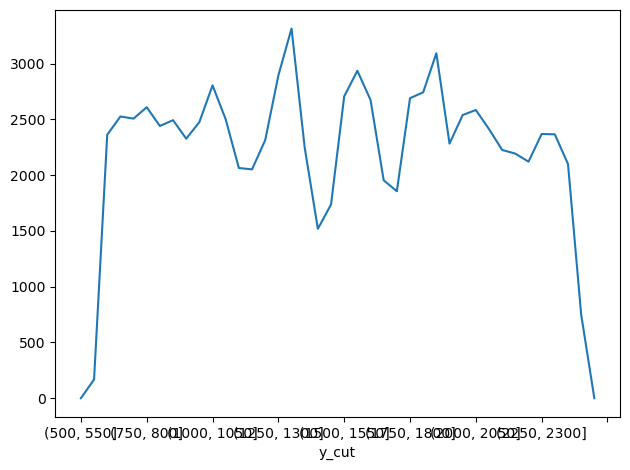

In [42]:
fig,ax = plt.subplots()
count[10:-5].plot(ax=ax)
fig.tight_layout()
#ax.set_xticklabels(ylabs[10:-5])

In [16]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt,Xt_ns,Xt_s):
    return (Xt_s+Xt_ns*np.exp(-t/Tt))*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Xb,Om):
    return Xb*np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
def Cbar_E(t,Tb,Xb):
    return Xb*np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xt_ns,Xt_s,Tb,Xb,Omega):
    return Cbar(t,Tb,Xb,Omega)+Ctilde(t,Tt,Xt_ns,Xt_s)
def C_E(t,Tt,Xt_ns,Xt_s,Tb,Xb):
    return Cbar_E(t,Tb,Xb)+Ctilde(t,Tt,Xt_ns,Xt_s)

In [17]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,0,0,0),(40,np.inf,np.inf,2000,np.inf,1)) # bounds for the fit to avoid non physical results
bounds_E = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf))
ce,cl = 'lightseagreen','firebrick'
sig = signature(myfunc)
Nparams = len([V for V in sig.parameters.keys()][1:]) # Number of parameters to fit

#### Following cells are test of bootstrap method for 1 bin

In [103]:
y = df_chunked.y_cut.compute()

In [106]:
df_bin1 = df_chunked.groupby('y_cut').get_group(y.iloc[0]).compute()

In [107]:
# Drop columns so that only the ones corresponding to timelag remains
resample_bin = df_bin1.drop(columns=['y_cut','id','time','x','y'])

In [108]:
#Resample B times and stock means in a dataframe. _ds contains B average in the bin of the B resampling
B = 100
_ds = pd.concat([resample_bin.sample(frac=1,replace=True,axis='index'
                                    ).mean('index').rename('sample_%s'%(i+1)) for i in range(B)
                ],axis='columns')

In [109]:
# Add "true" correlation from the oriiginal dataset (no resampling)
_ds = pd.concat([resample_bin.mean('index').rename('Original'),_ds],axis='columns')

,Original,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100
0.000000,0.036446,0.037071,0.036305,0.035654,0.035366,0.036812,0.035931,0.037627,0.036033,0.036501,...,0.035751,0.037011,0.035720,0.036456,0.036670,0.037410,0.036607,0.036371,0.035188,0.036193
0.006944,0.036412,0.037036,0.036271,0.035620,0.035333,0.036778,0.035898,0.037593,0.035999,0.036467,...,0.035717,0.036978,0.035686,0.036422,0.036636,0.037376,0.036573,0.036337,0.035154,0.036160
0.013889,0.036309,0.036933,0.036169,0.035517,0.035230,0.036675,0.035795,0.037490,0.035896,0.036365,...,0.035615,0.036875,0.035583,0.036320,0.036533,0.037273,0.036471,0.036235,0.035052,0.036058
0.020833,0.036139,0.036762,0.035999,0.035347,0.035060,0.036505,0.035625,0.037319,0.035726,0.036195,...,0.035445,0.036704,0.035413,0.036150,0.036363,0.037103,0.036300,0.036065,0.034881,0.035888
0.027778,0.035902,0.036524,0.035763,0.035110,0.034824,0.036268,0.035389,0.037081,0.035489,0.035958,...,0.035209,0.036467,0.035176,0.035913,0.036125,0.036866,0.036063,0.035828,0.034644,0.035653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39.972222,-0.000498,-0.000545,-0.000398,-0.000296,-0.000431,-0.000641,-0.000395,-0.000194,-0.000790,-0.000578,...,-0.000524,-0.000360,-0.000814,-0.000387,-0.000483,-0.000333,-0.000569,-0.000846,-0.000261,-0.000247
39.979167,-0.000492,-0.000540,-0.000385,-0.000292,-0.000427,-0.000639,-0.000390,-0.000199,-0.000781,-0.000573,...,-0.000517,-0.000354,-0.000804,-0.000385,-0.000483,-0.000334,-0.000565,-0.000841,-0.000251,-0.000242
39.986111,-0.000487,-0.000537,-0.000372,-0.000290,-0.000424,-0.000636,-0.000385,-0.000205,-0.000773,-0.000568,...,-0.000510,-0.000349,-0.000795,-0.000383,-0.000483,-0.000336,-0.000561,-0.000836,-0.000241,-0.000237
39.993056,-0.000482,-0.000533,-0.000360,-0.000287,-0.000421,-0.000634,-0.000379,-0.000211,-0.000765,-0.000563,...,-0.000504,-0.000343,-0.000786,-0.000383,-0.000484,-0.000338,-0.000556,-0.000830,-0.000232,-0.000232


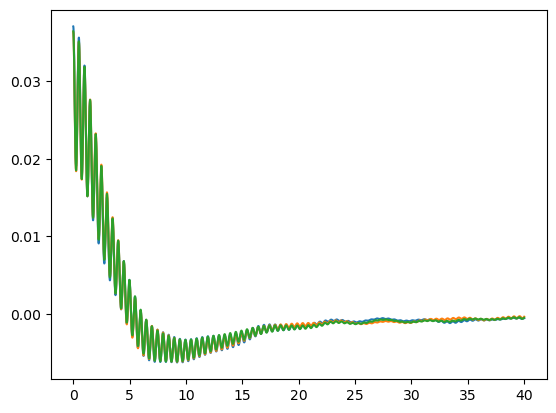

In [110]:
_ds['sample_1'].plot()
_ds['sample_2'].plot()
_ds['Original'].plot()
_ds

In [116]:
df_bin1.count()

time                  2894
x                     2894
y                     2894
id                    2894
0.0                   2894
                      ... 
39.979166666666664    2894
39.98611111111111     2894
39.99305555555555     2894
40.0                  2894
y_cut                 2894
Length: 5766, dtype: int64

In [111]:
# Fix index type as float
_ds.index = _ds.index.astype('float64')

In [112]:
# Fitting operation for each averaged sample
if np.isnan(_ds['Original']).any():
        print('Failed') # original sample for Nans, fit won't work otherwise (==removing bins with no data)

In [113]:
#Run the fit : param_fit compute optimal values of fit using non linear least square regression,
#outputs are the best fit parameters estimates
fitted = pd.concat([param_fit(_ds[sample],myfunc,bounds,X='') for sample in _ds.columns],axis='columns')
fitted

,Original,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100
Tt,4.555652e+00,4.740821e+00,4.597360e+00,4.445843e+00,4.577833e+00,4.586387e+00,4.407865e+00,4.597845e+00,4.503707e+00,4.510850e+00,...,4.729929e+00,4.466090e+00,4.532076e+00,4.559819e+00,4.481194,4.629728e+00,4.625437e+00,4.601344e+00,4.660580e+00,4.632483e+00
Xt_ns,9.375868e-03,9.262732e-03,9.362649e-03,9.476261e-03,9.395787e-03,9.324807e-03,9.456723e-03,9.326517e-03,9.427694e-03,9.369544e-03,...,9.333017e-03,9.392776e-03,9.404415e-03,9.357447e-03,0.009383,9.262986e-03,9.370942e-03,9.376469e-03,9.410529e-03,9.315719e-03
Xt_s,1.334106e-29,2.255728e-28,7.392709e-31,6.279957e-30,1.311507e-28,5.738732e-24,6.081615e-31,9.122149e-18,1.124535e-29,9.635685e-25,...,2.502426e-25,2.086219e-30,1.288056e-19,7.252825e-30,0.000007,1.139994e-27,8.392298e-31,7.384884e-33,2.242577e-28,7.907374e-31
Tb,5.554272e+00,5.572639e+00,5.663051e+00,5.681697e+00,5.448756e+00,5.244727e+00,5.673356e+00,5.607545e+00,5.522818e+00,5.696871e+00,...,5.606935e+00,5.824352e+00,5.612264e+00,5.305679e+00,5.362326,5.769571e+00,5.729544e+00,5.391793e+00,5.539441e+00,5.661238e+00
Xb,2.902104e-02,2.905506e-02,2.889659e-02,2.792844e-02,2.838813e-02,2.981312e-02,2.835450e-02,2.985668e-02,2.851365e-02,2.900519e-02,...,2.812752e-02,2.924137e-02,2.866616e-02,2.905337e-02,0.029489,2.913730e-02,2.881132e-02,2.876346e-02,2.782105e-02,2.885478e-02
Omega,4.395054e-02,4.418007e-02,4.396120e-02,4.233802e-02,4.398558e-02,4.485014e-02,4.313250e-02,4.409768e-02,4.300428e-02,4.423646e-02,...,4.409791e-02,4.320174e-02,4.385351e-02,4.438371e-02,0.043421,4.287845e-02,4.385979e-02,4.354050e-02,4.397228e-02,4.405164e-02


In [117]:
# Compute deltastar, each sample results minus the original ones
deltastar = fitted.sub(fitted['Original'],axis='index')

In [118]:
# Compute the quantiles for all columns of deltastar (except the original one which is zero)
# with alpha the interval oc confidence wanted, 0.05 by default in the function wrap_bootstrap
alpha=0.05
q = deltastar.loc[:,'sample_1':].quantile([alpha,1-alpha], axis='columns')
q

# Define upper ond lower limits of the interval of confidence
deltau = q.iloc[0]
deltal = q.iloc[1]

In [119]:
#Define the interval : original estimates minus the lower and upper limits
ci = [fitted['Original'].sub(deltal,axis='index'),fitted['Original'].sub(deltau,axis='index')]
ci

[Tt       4.404834e+00
 Xt_ns    9.301428e-03
 Xt_s    -1.211827e-17
 Tb       5.259669e+00
 Xb       2.754169e-02
 Omega    4.237253e-02
 dtype: float64,
 Tt       4.671801e+00
 Xt_ns    9.474333e-03
 Xt_s     2.668002e-29
 Tb       5.822224e+00
 Xb       3.016682e-02
 Omega    4.533256e-02
 dtype: float64]

In [120]:
#Pit everything in a dataframe
out = pd.DataFrame(np.array([ci[0].values]),columns=[V+'_lower' for V in fitted.index.values])#,index=y.unique())
for V in fitted.index.values:
    out[V+'_upper'] = ci[1][V]
    out[V] = fitted['Original'][V]
out

,Tt_lower,Xt_ns_lower,Xt_s_lower,Tb_lower,Xb_lower,Omega_lower,Tt_upper,Tt,Xt_ns_upper,Xt_ns,Xt_s_upper,Xt_s,Tb_upper,Tb,Xb_upper,Xb,Omega_upper,Omega
0,4.404834,0.009301,-1.211827e-17,5.259669,0.027542,0.042373,4.671801,4.555652,0.009474,0.009376,2.668002e-29,1.334106e-29,5.822224,5.554272,0.030167,0.029021,0.045333,0.043951


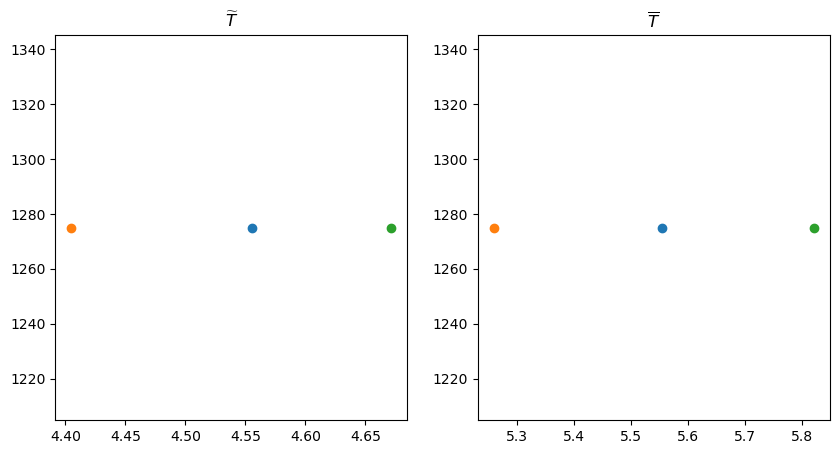

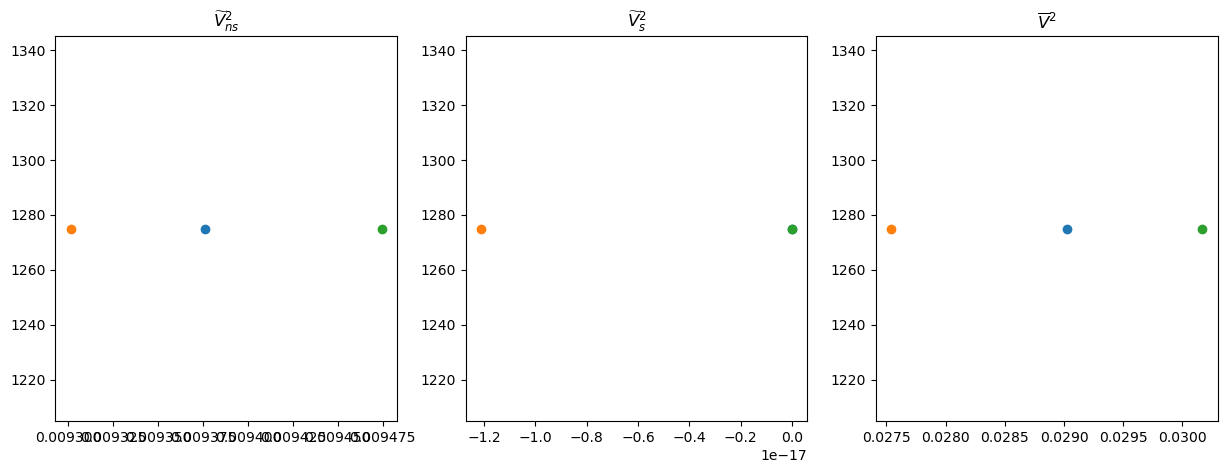

In [122]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for V,ax,title in zip(['Tt','Tb'],axs,[r'$\widetilde{T}$',r'$\overline{T}$']):
    ax.scatter(out[V],df_bin1.y_cut.iloc[0].mid)
    ax.scatter(out[V+'_lower'],df_bin1.y_cut.iloc[0].mid)
    ax.scatter(out[V+'_upper'],df_bin1.y_cut.iloc[0].mid)
    ax.set_title(title)
fig,axs = plt.subplots(1,3,figsize=(15,5))
for V,ax,title in zip(['Xt_ns','Xt_s','Xb'],axs,[r'$\widetilde{V}_{ns}^2$',r'$\widetilde{V}_{s}^2$',
                                                 r'$\overline{V}^2$']):
    ax.scatter(out[V],df_bin1.y_cut.iloc[0].mid)
    ax.scatter(out[V+'_lower'],df_bin1.y_cut.iloc[0].mid)
    ax.scatter(out[V+'_upper'],df_bin1.y_cut.iloc[0].mid)
    ax.set_title(title)    

#### End of test cells

### Run wrap_bootstrap over all bins

In [ ]:
params = [V for V in sig.parameters.keys()][1:]
titles = [r'$\widetilde{T}$',r'$\widetilde{V}_{ns}^2$',r'$\widetilde{V}_{s}^2$',r'$\overline{T}$',r'$\overline{V}^2$',r'$\Omega$']

B = 2

In [137]:
B = 2
df_boot = df_chunked.groupby(['y_cut']).apply(wrap_bootstrap,B,C,bounds).persist()
df_boot

<ipython-input-137-b1c75d9ab034>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_boot = df_chunked.groupby(['y_cut']).apply(wrap_bootstrap,B,C,bounds).persist()


,Tt_lower,Xt_ns_lower,Xt_s_lower,Tb_lower,Xb_lower,Omega_lower,Tt_upper,Tt,Xt_ns_upper,Xt_ns,Xt_s_upper,Xt_s,Tb_upper,Tb,Xb_upper,Xb,Omega_upper,Omega
npartitions=30,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [138]:
df_boot_2 = df_boot.compute()
df_boot_2 = df_boot_2.reset_index().drop(columns='level_1')
df_boot_2 = df_boot_2.set_index(df_boot_2.y_cut.apply(lambda x: x.mid)).sort_index().to_xarray()
df_boot_2

<xarray.Dataset>
Dimensions:      (y_cut: 38)
Coordinates:
  * y_cut        (y_cut) object (550, 600] (600, 650] ... (2400, 2450]
Data variables: (12/18)
    Tt_lower     (y_cut) float64 10.76 10.97 12.63 13.42 ... 13.4 13.6 13.79
    Xt_ns_lower  (y_cut) float64 0.002429 0.002774 0.003288 ... 0.01244 0.01132
    Xt_s_lower   (y_cut) float64 0.00528 0.005072 0.004681 ... 0.004727 0.007918
    Tb_lower     (y_cut) float64 101.8 39.75 44.45 52.03 ... 38.74 52.53 31.21
    Xb_lower     (y_cut) float64 0.0002596 0.0003448 ... 0.000226 0.0001313
    Omega_lower  (y_cut) float64 0.02042 0.02071 0.02033 ... 0.01909 0.01894
    ...           ...
    Tb_upper     (y_cut) float64 105.4 41.4 45.27 53.48 ... 40.44 53.65 32.26
    Tb           (y_cut) float64 95.86 40.87 44.64 52.04 ... 40.61 52.39 32.05
    Xb_upper     (y_cut) float64 0.0002824 0.0003525 ... 0.0002349 0.0001368
    Xb           (y_cut) float64 0.0002818 0.0003451 ... 0.0002222 0.0001378
    Omega_upper  (y_cut) float64 0.0206 0.02102 0.02046 ... 0.01943 0.01951
    Omega        (y_cut) float64 0.02062 0.02073 0.02053 ... 0.01917 0.01941

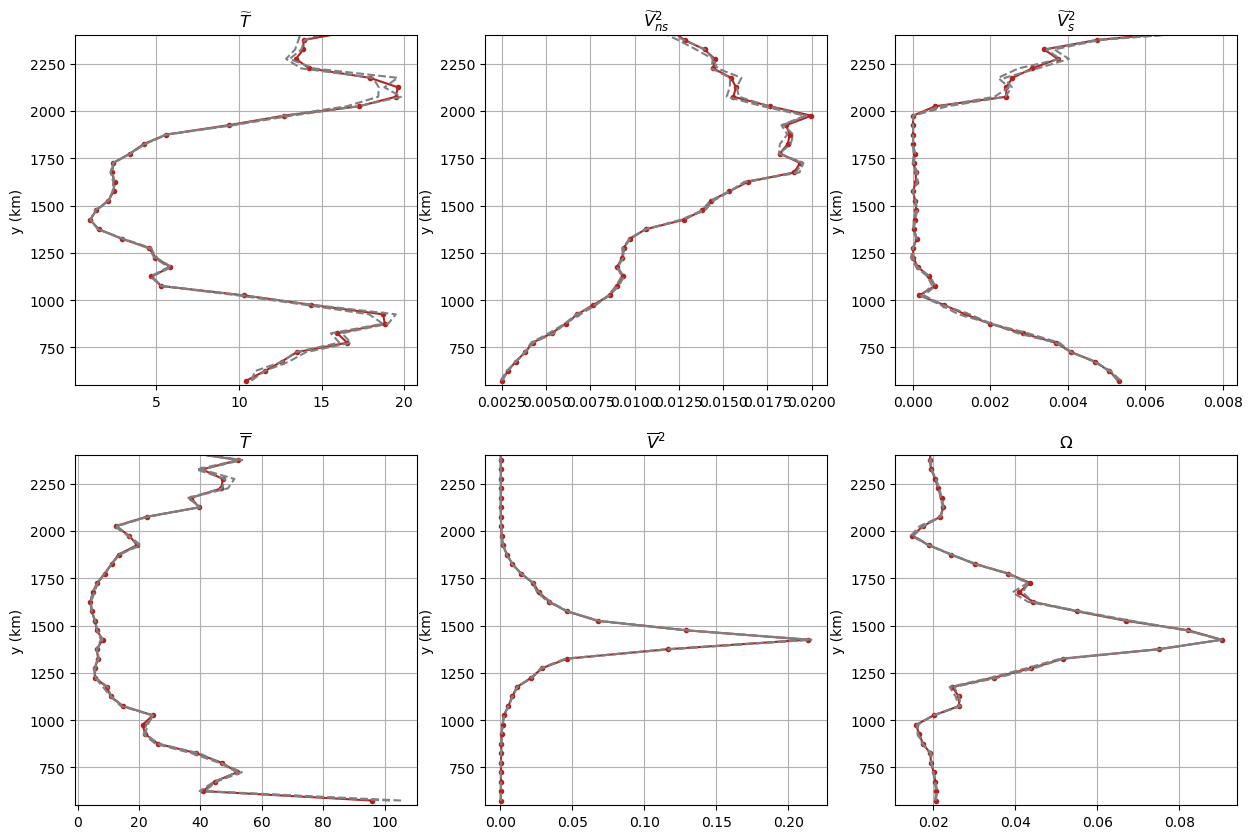

In [139]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax,title in zip(params[:3],axs[0,:],titles[:3]):
    df_boot_2[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_2[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_2[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)
for p,ax,title in zip(params[3:],axs[1,:],titles[3:]):
    df_boot_2[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_2[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_2[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)

B = 10

In [124]:
B = 10
df_boot = df_chunked.groupby(['y_cut']).apply(wrap_bootstrap,B,C,bounds).persist()
df_boot

<ipython-input-124-742de9650f5d>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_boot = df_chunked.groupby(['y_cut']).apply(wrap_bootstrap,B,C,bounds).persist()


,Tt_lower,Xt_ns_lower,Xt_s_lower,Tb_lower,Xb_lower,Omega_lower,Tt_upper,Tt,Xt_ns_upper,Xt_ns,Xt_s_upper,Xt_s,Tb_upper,Tb,Xb_upper,Xb,Omega_upper,Omega
npartitions=30,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [127]:
df_boot_10 = df_boot.compute()
df_boot_10 = df_boot_10.reset_index().drop(columns='level_1')
df_boot_10 = df_boot_10.set_index(df_boot_10.y_cut.apply(lambda x: x.mid)).sort_index().to_xarray()
df_boot_10

<xarray.Dataset>
Dimensions:      (y_cut: 38)
Coordinates:
  * y_cut        (y_cut) object (550, 600] (600, 650] ... (2400, 2450]
Data variables: (12/18)
    Tt_lower     (y_cut) float64 9.282 11.09 12.05 13.1 ... 13.24 12.91 15.14
    Xt_ns_lower  (y_cut) float64 0.002083 0.002779 0.003094 ... 0.01251 0.01164
    Xt_s_lower   (y_cut) float64 0.005115 0.004985 0.00463 ... 0.004479 0.006889
    Tb_lower     (y_cut) float64 64.33 39.42 42.65 48.26 ... 37.89 50.64 29.41
    Xb_lower     (y_cut) float64 0.0002337 0.0003355 ... 0.0002103 0.0001307
    Omega_lower  (y_cut) float64 0.02014 0.02069 0.02037 ... 0.019 0.01892
    ...           ...
    Tb_upper     (y_cut) float64 114.7 43.32 46.29 54.99 ... 42.64 53.83 34.48
    Tb           (y_cut) float64 95.86 40.87 44.64 52.04 ... 40.61 52.39 32.05
    Xb_upper     (y_cut) float64 0.0003182 0.0003576 ... 0.0002304 0.0001491
    Xb           (y_cut) float64 0.0002818 0.0003451 ... 0.0002222 0.0001378
    Omega_upper  (y_cut) float64 0.02105 0.02093 0.02078 ... 0.01938 0.01969
    Omega        (y_cut) float64 0.02062 0.02073 0.02053 ... 0.01917 0.01941

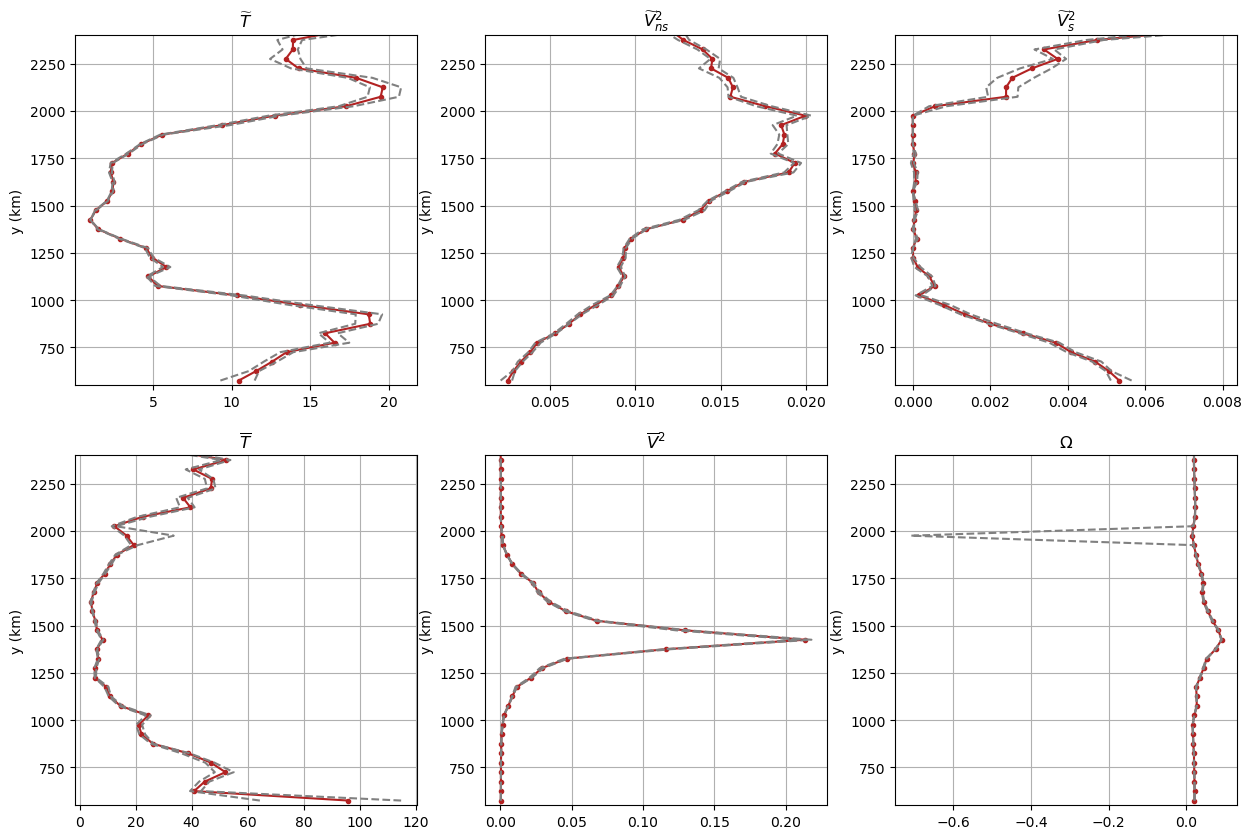

In [129]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax,title in zip(params[:3],axs[0,:],titles[:3]):
    df_boot_10[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_10[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_10[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)
for p,ax,title in zip(params[3:],axs[1,:],titles[3:]):
    df_boot_10[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_10[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_10[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)

B = 100

In [130]:
B = 100
df_boot = df_chunked.groupby(['y_cut']).apply(wrap_bootstrap,B,C,bounds).persist()
df_boot

<ipython-input-130-2ebcab75ec67>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_boot = df_chunked.groupby(['y_cut']).apply(wrap_bootstrap,B,C,bounds).persist()


,Tt_lower,Xt_ns_lower,Xt_s_lower,Tb_lower,Xb_lower,Omega_lower,Tt_upper,Tt,Xt_ns_upper,Xt_ns,Xt_s_upper,Xt_s,Tb_upper,Tb,Xb_upper,Xb,Omega_upper,Omega
npartitions=30,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [131]:
df_boot_100 = df_boot.compute()
df_boot_100 = df_boot_100.reset_index().drop(columns='level_1')
df_boot_100 = df_boot_100.set_index(df_boot_100.y_cut.apply(lambda x: x.mid)).sort_index().to_xarray()
df_boot_100

<xarray.Dataset>
Dimensions:      (y_cut: 38)
Coordinates:
  * y_cut        (y_cut) object (550, 600] (600, 650] ... (2400, 2450]
Data variables: (12/18)
    Tt_lower     (y_cut) float64 8.818 11.0 11.95 12.85 ... 13.22 13.07 15.23
    Xt_ns_lower  (y_cut) float64 0.002118 0.002751 0.003181 ... 0.01233 0.01122
    Xt_s_lower   (y_cut) float64 0.005074 0.004984 0.004632 ... 0.004358 0.00669
    Tb_lower     (y_cut) float64 54.96 38.96 42.64 48.78 ... 38.33 49.94 28.91
    Xb_lower     (y_cut) float64 0.0002241 0.0003306 ... 0.0002082 0.0001253
    Omega_lower  (y_cut) float64 0.02005 0.02045 0.02024 ... 0.01896 0.01894
    ...           ...
    Tb_upper     (y_cut) float64 117.9 43.65 46.46 54.38 ... 42.49 55.06 34.37
    Tb           (y_cut) float64 95.86 40.87 44.64 52.04 ... 40.61 52.39 32.05
    Xb_upper     (y_cut) float64 0.0003441 0.000358 ... 0.0002343 0.0001462
    Xb           (y_cut) float64 0.0002818 0.0003451 ... 0.0002222 0.0001378
    Omega_upper  (y_cut) float64 0.02128 0.02096 0.02075 ... 0.01939 0.01987
    Omega        (y_cut) float64 0.02062 0.02073 0.02053 ... 0.01917 0.01941

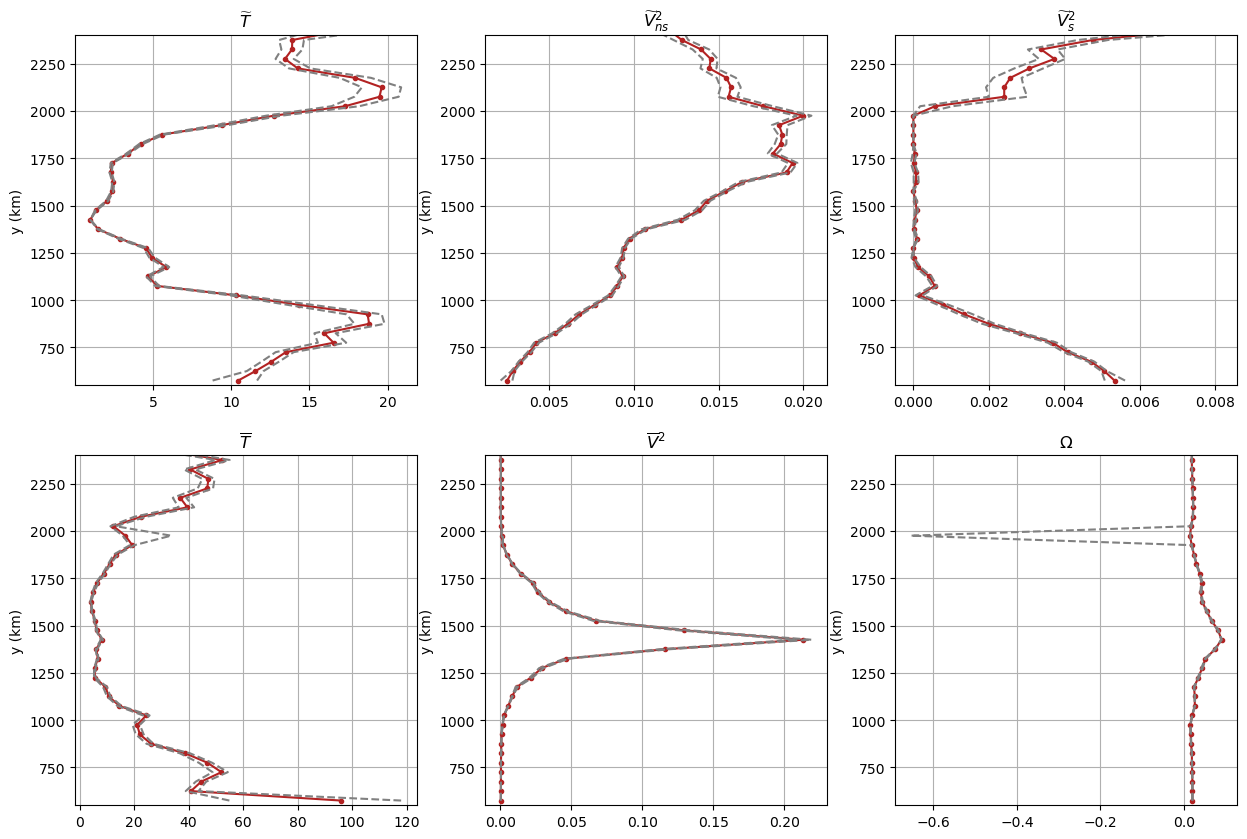

In [132]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax,title in zip(params[:3],axs[0,:],titles[:3]):
    df_boot_100[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_100[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_100[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)
for p,ax,title in zip(params[3:],axs[1,:],titles[3:]):
    df_boot_100[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_100[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_100[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)

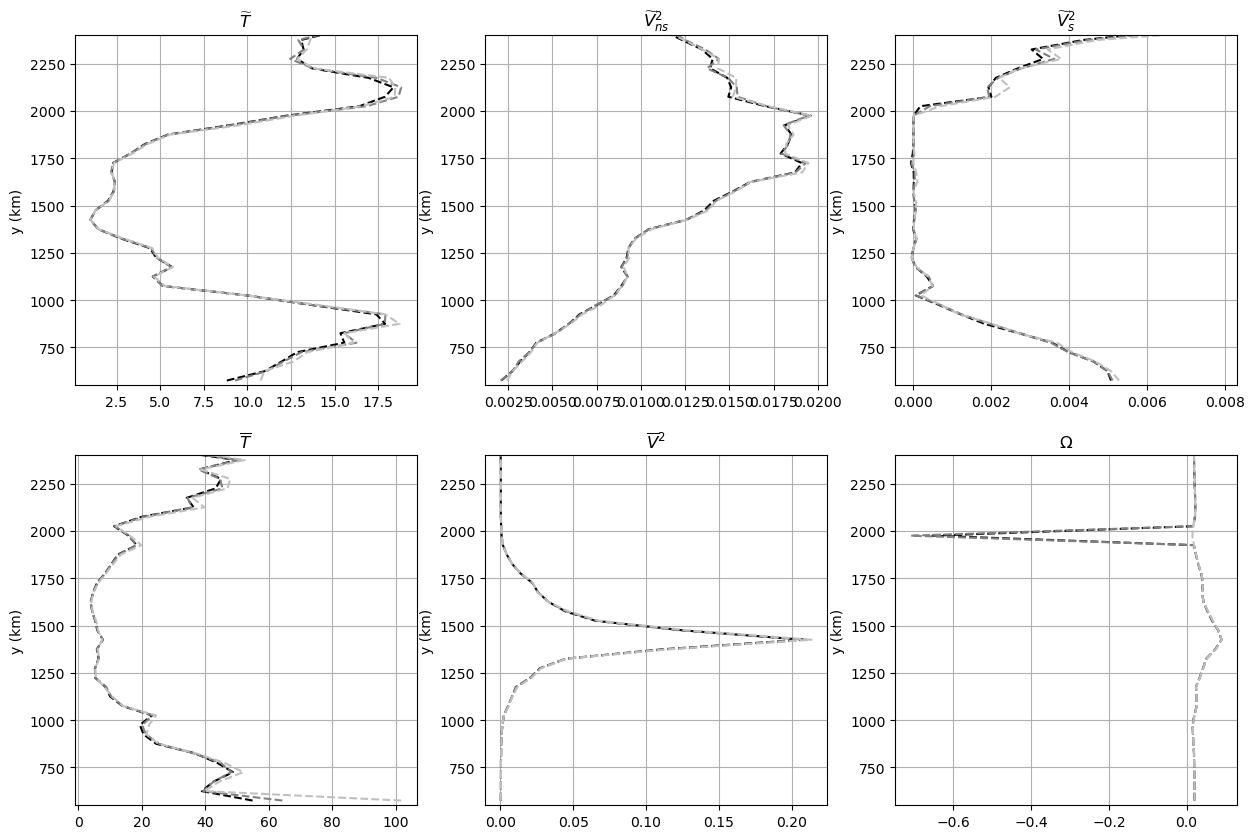

In [140]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax,title in zip(params[:3],axs[0,:],titles[:3]):
    #df_boot_100[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_100[p+'_lower'].plot(ax=ax,y='y_cut',c='k',linestyle='--')
    df_boot_10[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_2[p+'_lower'].plot(ax=ax,y='y_cut',c='silver',linestyle='--')
    #df_boot_100[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)
for p,ax,title in zip(params[3:],axs[1,:],titles[3:]):
    df_boot_100[p+'_lower'].plot(ax=ax,y='y_cut',c='k',linestyle='--')
    df_boot_10[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_2[p+'_lower'].plot(ax=ax,y='y_cut',c='silver',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)

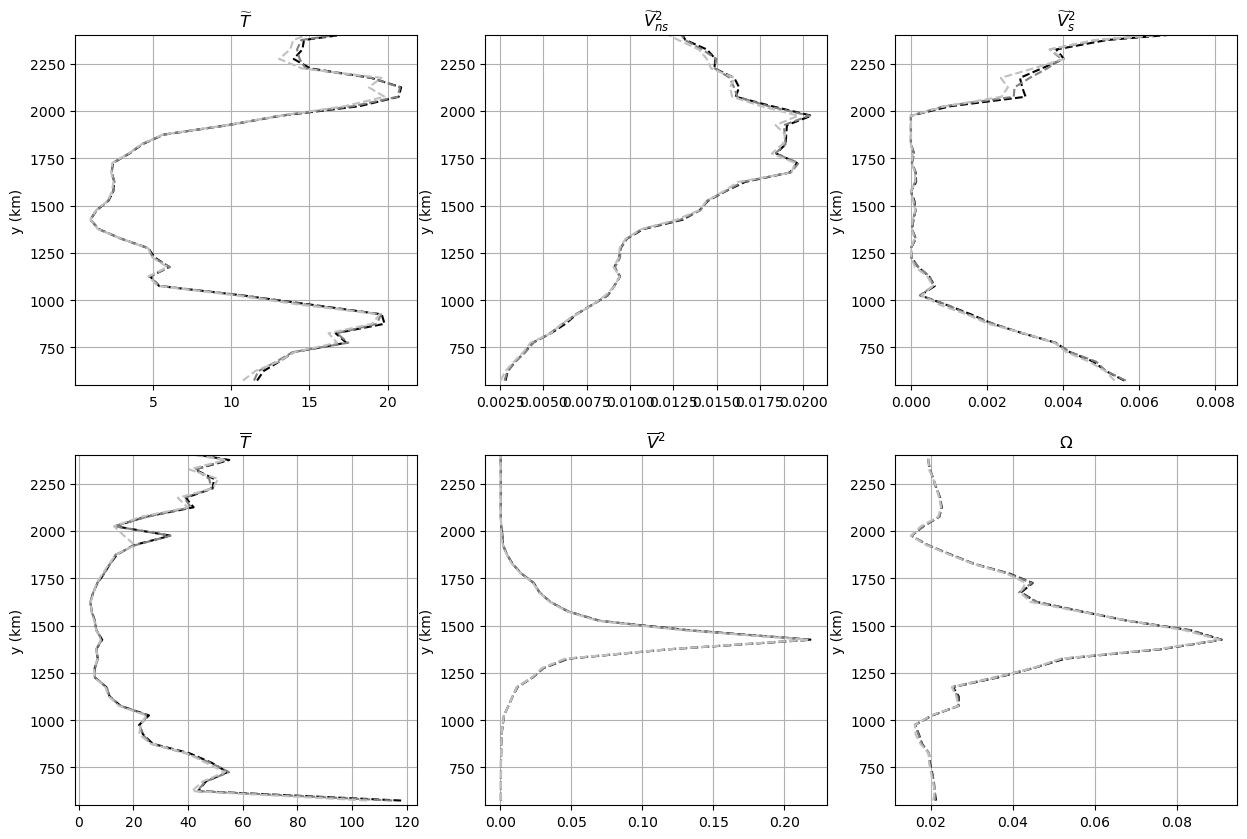

In [141]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax,title in zip(params[:3],axs[0,:],titles[:3]):
    #df_boot_100[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    df_boot_100[p+'_upper'].plot(ax=ax,y='y_cut',c='k',linestyle='--')
    df_boot_10[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_2[p+'_upper'].plot(ax=ax,y='y_cut',c='silver',linestyle='--')
    #df_boot_100[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)
for p,ax,title in zip(params[3:],axs[1,:],titles[3:]):
    df_boot_100[p+'_upper'].plot(ax=ax,y='y_cut',c='k',linestyle='--')
    df_boot_10[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    df_boot_2[p+'_upper'].plot(ax=ax,y='y_cut',c='silver',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)

B = 500

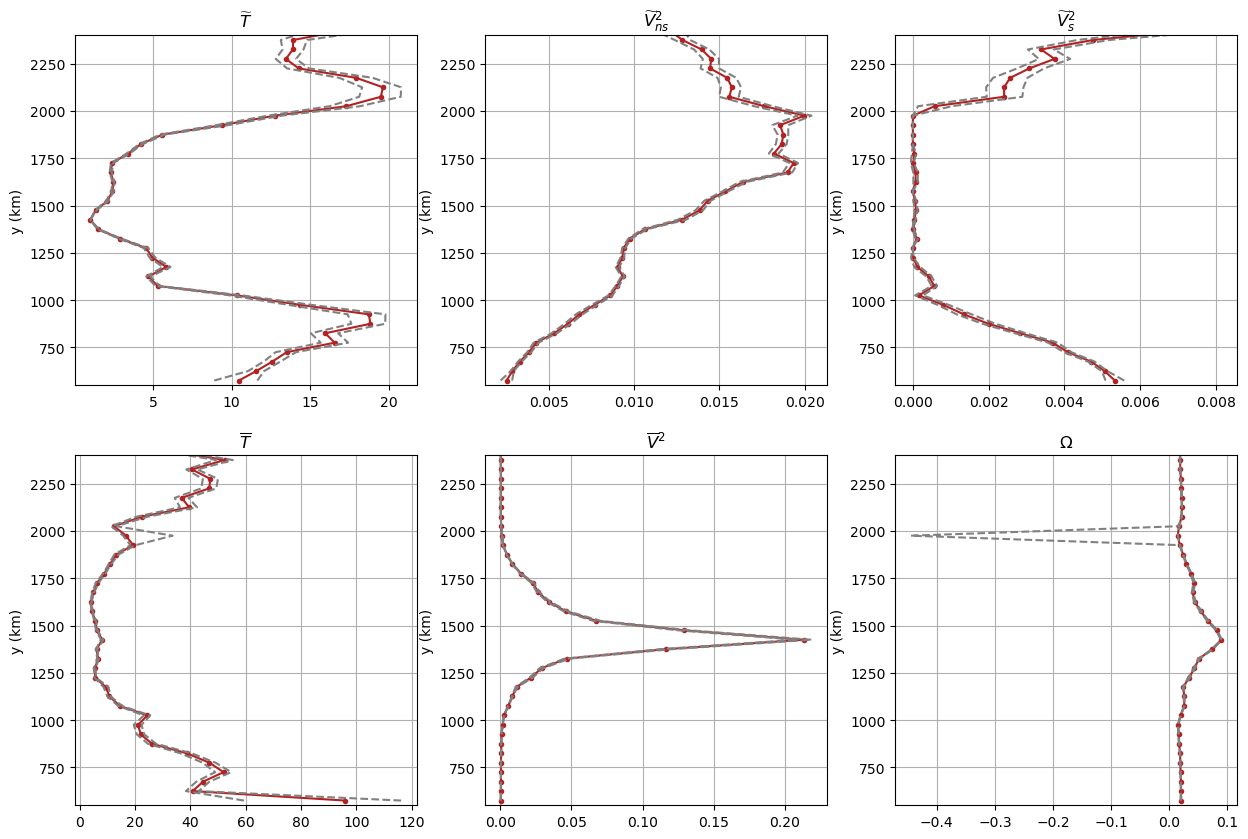

In [22]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax,title in zip(params[:3],axs[0,:],titles[:3]):
    res[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    res[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    res[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)
for p,ax,title in zip(params[3:],axs[1,:],titles[3:]):
    res[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    res[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    res[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)

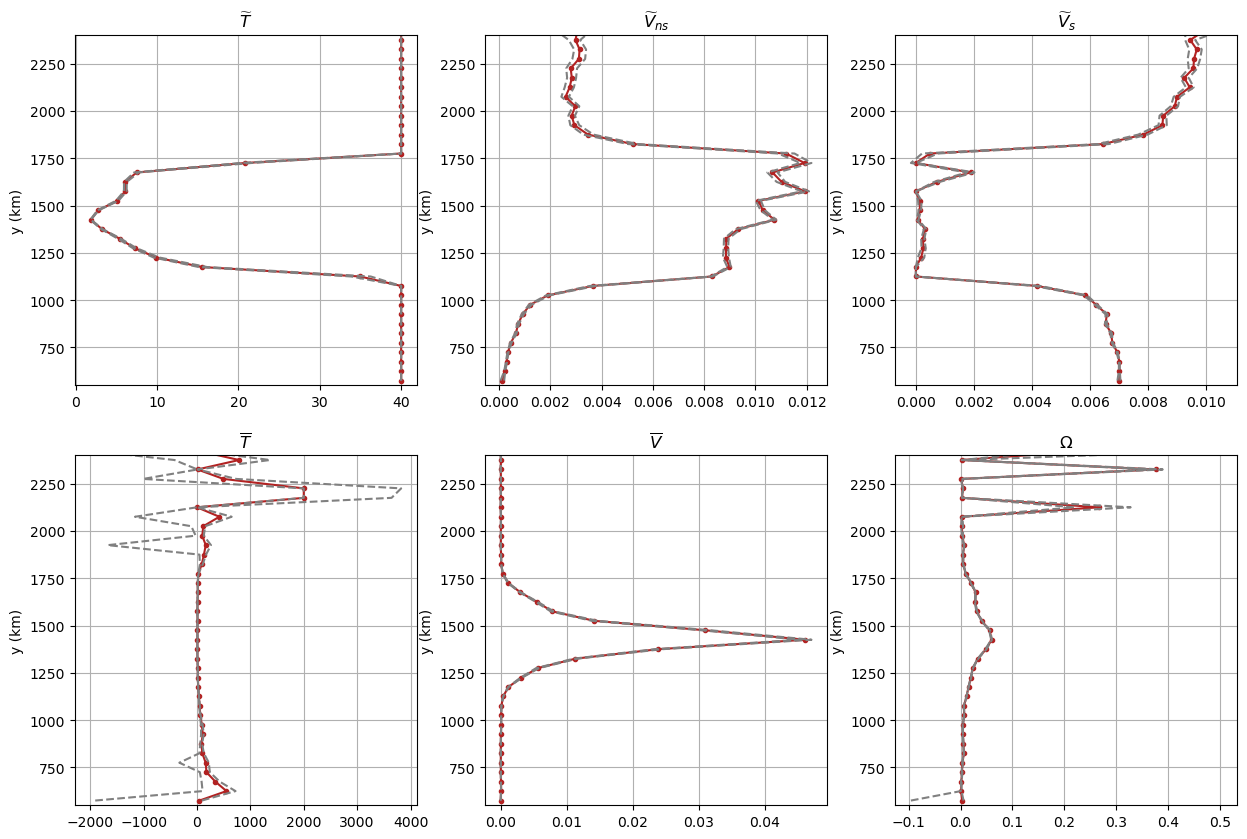

In [46]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax,title in zip(params[:3],axs[0,:],titles[:3]):
    res[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    res[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    res[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)
for p,ax,title in zip(params[3:],axs[1,:],titles[3:]):
    res[p].plot(ax=ax,y='y_cut',c='firebrick',marker='.')
    res[p+'_lower'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    res[p+'_upper'].plot(ax=ax,y='y_cut',c='grey',linestyle='--')
    ax.grid();ax.set_ylim(550,2400);ax.set_ylabel('y (km)');ax.set_xlabel('')
    ax.set_title(title)

In [142]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
